In [21]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

from tensorflow.keras.utils import Sequence 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [2]:
train_path =r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\train'
train_path
val_path = r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\val'
val_path
test_path = r'C:\Users\THOTA SIDDARTHA\Downloads\organised_maize\test'
test_path

'C:\\Users\\THOTA SIDDARTHA\\Downloads\\organised_maize\\test'

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

Train_Image = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Val_Image = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Test_Image = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Class indices:", Train_Image.class_indices)

# Print number of samples in each subset
print("Number of training samples:", Train_Image.samples)
print("Number of validation samples:", Val_Image.samples)
print("Number of testing samples:", Test_Image.samples)

Found 2400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'Bercak Daun': 0, 'Daun Sehat': 1, 'Hawar Daun': 2, 'Karat Daun': 3}
Number of training samples: 2400
Number of validation samples: 800
Number of testing samples: 800


In [5]:
train_class = Train_Image.num_classes
train_class

4

In [6]:
test_class = Test_Image.num_classes
test_class

4

In [7]:
Mobilenet = MobileNetV2(weights='imagenet', include_top = False, input_shape = (img_height,img_width,3))

In [8]:
for i in Mobilenet.layers:
    i.trainable = False

In [9]:
def main_model(tl_model,class1):
    m_model = tl_model.output
    m_model = GlobalAveragePooling2D()(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(1024,activation='relu')(m_model)
    m_model = Dense(512,activation='relu')(m_model)
    m_model = Dense(class1,activation = 'softmax')(m_model)
    return m_model


In [10]:
combining_model = main_model(Mobilenet,train_class)


In [11]:
model = Model(inputs=Mobilenet.input, outputs=combining_model)

In [12]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [13]:
history = model.fit(Train_Image,steps_per_epoch=Train_Image.samples // batch_size, epochs=50,validation_data=Val_Image,validation_steps=Val_Image.samples // batch_size)

Epoch 1/50
75/75 [==============================] - 179s 2s/step - loss: 0.6967 - accuracy: 0.7292 - val_loss: 0.7435 - val_accuracy: 0.6875
Epoch 2/50
75/75 [==============================] - 219s 3s/step - loss: 0.4239 - accuracy: 0.8254 - val_loss: 0.4199 - val_accuracy: 0.8250
Epoch 3/50
75/75 [==============================] - 211s 3s/step - loss: 0.3901 - accuracy: 0.8479 - val_loss: 0.4400 - val_accuracy: 0.8175
Epoch 4/50
75/75 [==============================] - 215s 3s/step - loss: 0.4159 - accuracy: 0.8413 - val_loss: 0.4347 - val_accuracy: 0.8175
Epoch 5/50
75/75 [==============================] - 254s 3s/step - loss: 0.3545 - accuracy: 0.8604 - val_loss: 0.6143 - val_accuracy: 0.7500
Epoch 6/50
75/75 [==============================] - 242s 3s/step - loss: 0.3465 - accuracy: 0.8712 - val_loss: 0.4737 - val_accuracy: 0.7962
Epoch 7/50
75/75 [==============================] - 238s 3s/step - loss: 0.3268 - accuracy: 0.8646 - val_loss: 0.6128 - val_accuracy: 0.7487
Epoch 8/50
75

In [15]:
Test_score = model.evaluate(Test_Image,steps = len(Test_Image))
Test_score

25/25 [==============================] - 74s 3s/step - loss: 0.5143 - accuracy: 0.8313


[0.5143419504165649, 0.831250011920929]

In [14]:
model.save("maize_mobilenet40_v2.h5")


In [22]:
with open('maize_mobilenet50.pkl', 'wb') as f:
    pickle.dump(model, f)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools 


target_names = []
for key in Train_Image.class_indices:
    target_names.append(key)

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

25/25 [==============================] - 83s 3s/step
Confusion Matrix
Confusion matrix, without normalization


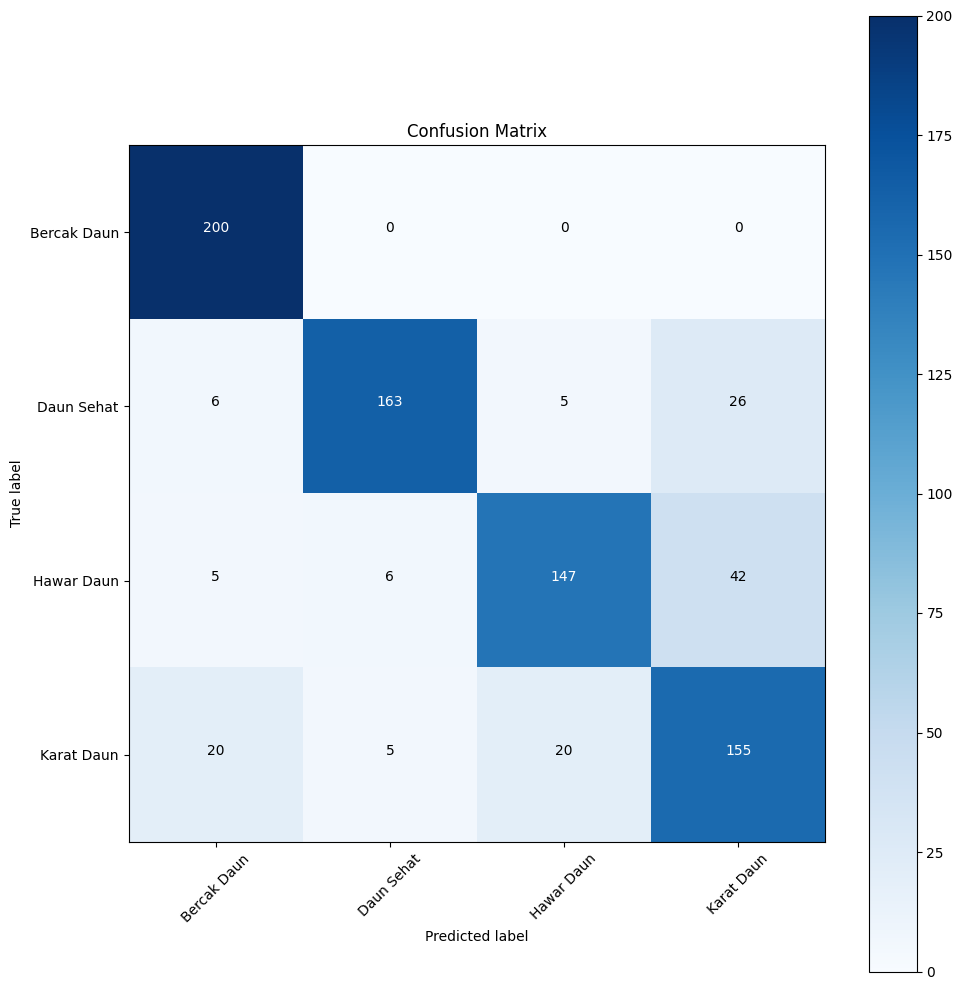

In [18]:
#Confution Matrix and Classification Report
Y_pred_Model = model.predict(Test_Image)
Y_pred_Model = np.argmax(Y_pred_Model, axis=-1)
print('Confusion Matrix') 
CM_Model=confusion_matrix(Test_Image.classes, Y_pred_Model)

plot_confusion_matrix(CM_Model, target_names, title='Confusion Matrix')


In [19]:
print('Classification Report')
print(classification_report(Test_Image.classes, Y_pred_Model, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

 Bercak Daun       0.87      1.00      0.93       200
  Daun Sehat       0.94      0.81      0.87       200
  Hawar Daun       0.85      0.73      0.79       200
  Karat Daun       0.70      0.78      0.73       200

    accuracy                           0.83       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.83      0.83       800



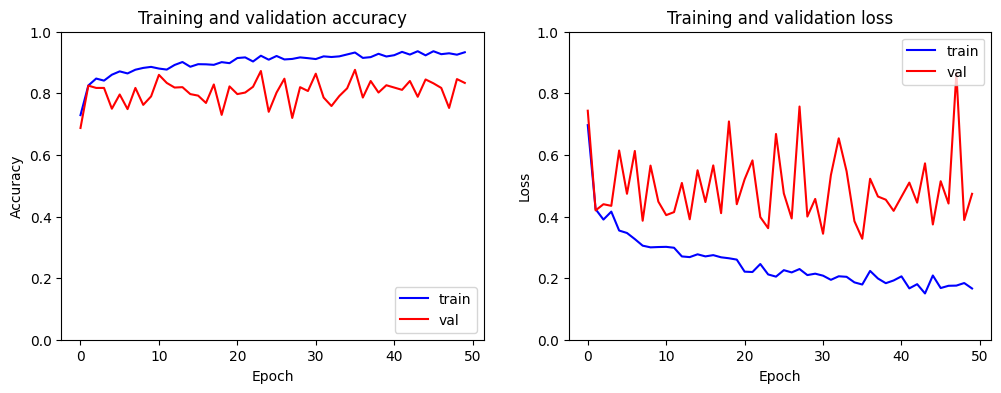

In [20]:
import matplotlib.pyplot as plt

Train_accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
Train_loss = history.history['loss']
Val_loss = history.history['val_loss']

epochs = range(len(Train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, Train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, Val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, Train_loss, 'b', label='Training loss')
plt.plot(epochs, Val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for loss

plt.show()
